# Eval Diffusion Model
### Imports

In [1]:
try: 
    import librosa
except:
    !pip install librosa

#Set Dir 
import sys, os
sys.path.append(os.path.abspath('..'))
# Torch
import torch
from torch import nn, Tensor
from torch.utils.data import DataLoader
import torch.optim as optim
# Utils
import numpy as np
from numpy import ndarray
import logging

# Base Scripts
from Libraries.U_Net import *
from Libraries.Diffusion import *
from Libraries.Utils import *
from MainScripts.Conf import conf

### Conf

In [2]:
remote_kernel: bool = True

device = "cuda" if torch.cuda.is_available() else "cpu"
model_name: str = "diffusion_v21"
training_data_name: str = "training_full_low_res"
model_path: str = path_to_remote_path("{}/{}".format(conf["paths"].model_path, model_name + ".pth"), remote_kernel)
logging_level: int = LIGHT_DEBUG
logging.basicConfig(level=logging_level, format='%(asctime)s - %(levelname)s - %(message)s')
logger: logging.Logger = logging.getLogger(__name__)

### Functions

In [3]:
def bwd_pass(model: Diffusion, n_samples: int = 1, file_name: str = "test") -> None:
    x: ndarray = model.bwd_diffusion(n_samples=n_samples)
    print(x[0,0].shape)
    for i in range(x.shape[0]):
        logger.info(f"Sample {i}")
        visualize_spectogram(x[i, 0])
        audio = spectrogram_to_audio(unnormalize(x[i, 0]), conf["audio"].len_fft)
        save_audio_file(audio, path_to_remote_path("{}/{}".format(conf["paths"].result_path, f"{file_name}_{i:02d}_out.wav"), remote_kernel))
    logger.light_debug("Saved passed through samples to {}".format(conf["paths"].result_path))



def print_eval_metrics(data: ndarray) -> None:
    if data.ndim == 2:
        data = np.expand_dims(data, axis = 0)
    for i, sample in enumerate(data):
        sc_score = spectral_convergence(sample, len_fft=conf["audio"].len_fft, hop_length=conf["audio"].len_hop, sample_rate=conf["audio"].sample_rate)
        sdr_score = sdr(sample, sample_rate=conf["audio"].sample_rate, cutoff=4000)
        print(f"Sample {(i + 1):02d} Spectral Convergence: {sc_score:.4f} SDR score: {sdr_score:.2f} dB")


### Data Loading & Model Creation

In [4]:
file = load_training_data(path_to_remote_path("{}/{}".format(conf["paths"].data_path, training_data_name + ".npy"), remote_kernel))[:100,...]
logger.info(f"Data loaded with shape: {file.shape}")

u_net = Conv_U_NET(in_channels=1,
                    time_embed_dim=conf["model"].time_embed_dim, 
                    n_starting_filters=conf["model"].n_starting_filters, 
                    n_downsamples=conf["model"].n_downsamples, 
                    activation=nn.GELU(), 
                    device=device,
                    conditional_norm=False
                ).to(device)

ema = EMA(u_net, decay = 0.999)

if os.path.exists(model_path):
    loaded_model = torch.load(model_path, map_location=device)
    u_net.load_state_dict(loaded_model["model"])
    logger.info(f"Model {model_name} loaded with {count_parameters(u_net)} Parameters")
    if ema is not None:
        for name, param in u_net.named_parameters():
            if param.requires_grad and name in loaded_model['ema_state']:
                ema.shadow[name] = loaded_model['ema_state'][name].clone()

else:
    raise AssertionError(f"No Model with {model_name} found!")

diffusion = Diffusion(model=u_net, 
                        noise_steps=conf["model"].diffusion_timesteps, 
                        noise_schedule="cosine", 
                        input_dim=[conf["model"].batch_size, 1, file.shape[-2], file.shape[-1]],
                        device=device,
                        ema=ema
                    )


2025-04-06 18:31:05,110 - LIGHT_DEBUG - Ndarray loaded from Data/training_full_low_res.npy of shape: (7087, 224, 416)
2025-04-06 18:31:05,112 - INFO - Data loaded with shape: (100, 224, 416)
2025-04-06 18:31:07,916 - INFO - Model diffusion_v21 loaded with 26981881 Parameters


### Evaluate

2025-04-06 18:31:08,103 - INFO - Started sampling 8 samples


2025-04-06 18:31:22,000 - LIGHT_DEBUG - Sampling timestep 100/1000 X min/max: -4.99132, 4.69368 noise min/max: -5.51123, 5.38980 std/mean: 1.10690, -0.08910 

2025-04-06 18:31:22,959 - LIGHT_DEBUG - Normalized to range: [-1,1]


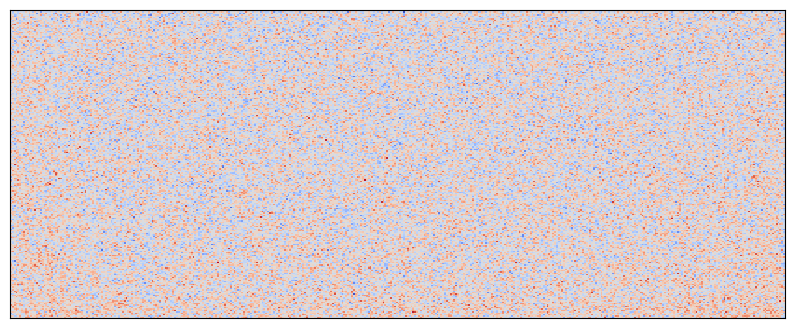

2025-04-06 18:31:36,000 - LIGHT_DEBUG - Sampling timestep 200/1000 X min/max: -4.88231, 4.38219 noise min/max: -5.27084, 5.11415 std/mean: 1.11077, -0.09470 

2025-04-06 18:31:36,881 - LIGHT_DEBUG - Normalized to range: [-1,1]


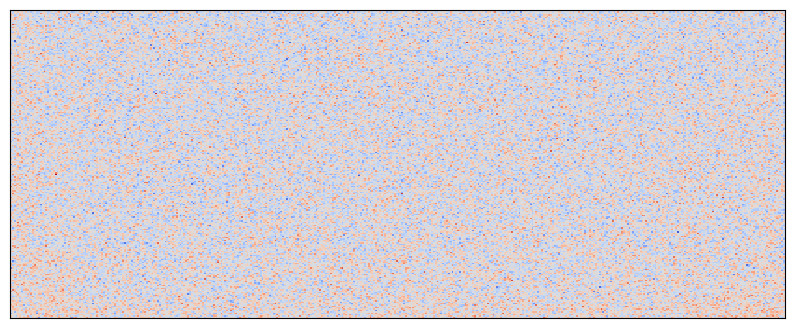

2025-04-06 18:31:50,000 - LIGHT_DEBUG - Sampling timestep 300/1000 X min/max: -5.02261, 4.43331 noise min/max: -5.34306, 5.11702 std/mean: 1.11649, -0.12731 

2025-04-06 18:31:50,872 - LIGHT_DEBUG - Normalized to range: [-1,1]


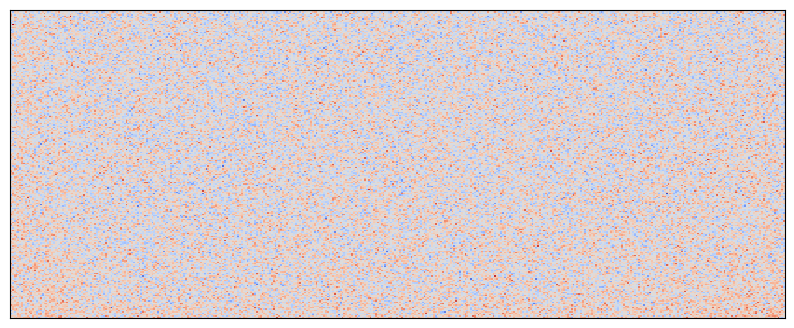

2025-04-06 18:32:04,000 - LIGHT_DEBUG - Sampling timestep 400/1000 X min/max: -4.86285, 4.09907 noise min/max: -5.26500, 4.92865 std/mean: 1.13072, -0.13701 

2025-04-06 18:32:05,018 - LIGHT_DEBUG - Normalized to range: [-1,1]


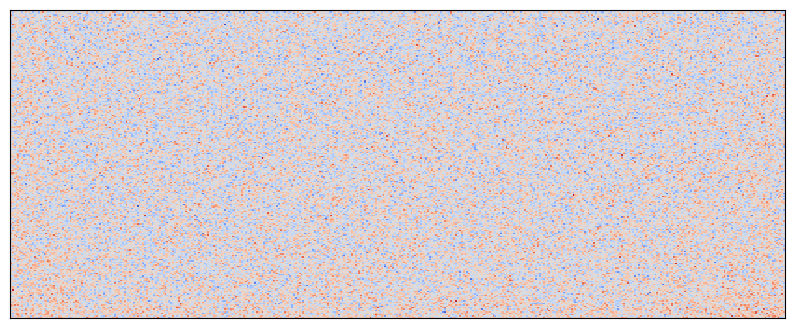

2025-04-06 18:32:19,000 - LIGHT_DEBUG - Sampling timestep 500/1000 X min/max: -4.99784, 4.32535 noise min/max: -5.41566, 5.11016 std/mean: 1.15029, -0.18647 

2025-04-06 18:32:19,245 - LIGHT_DEBUG - Normalized to range: [-1,1]


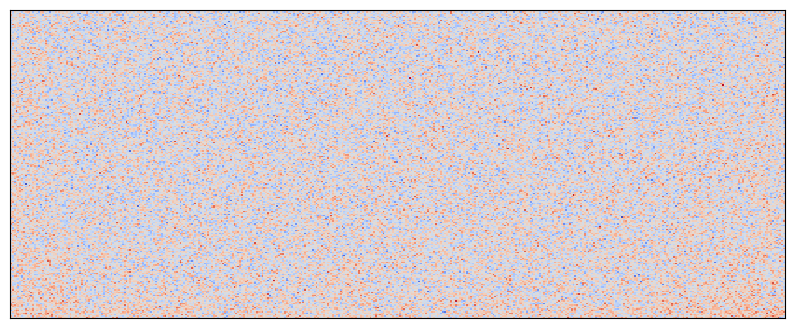

2025-04-06 18:32:33,000 - LIGHT_DEBUG - Sampling timestep 600/1000 X min/max: -5.27901, 4.01786 noise min/max: -5.67336, 5.17861 std/mean: 1.19346, -0.20852 

2025-04-06 18:32:33,520 - LIGHT_DEBUG - Normalized to range: [-1,1]


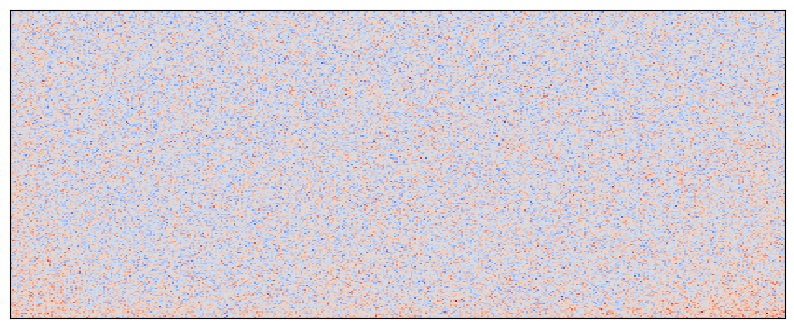

2025-04-06 18:32:47,000 - LIGHT_DEBUG - Sampling timestep 700/1000 X min/max: -5.30888, 4.35301 noise min/max: -6.60202, 5.52851 std/mean: 1.24730, -0.25937 

2025-04-06 18:32:47,799 - LIGHT_DEBUG - Normalized to range: [-1,1]


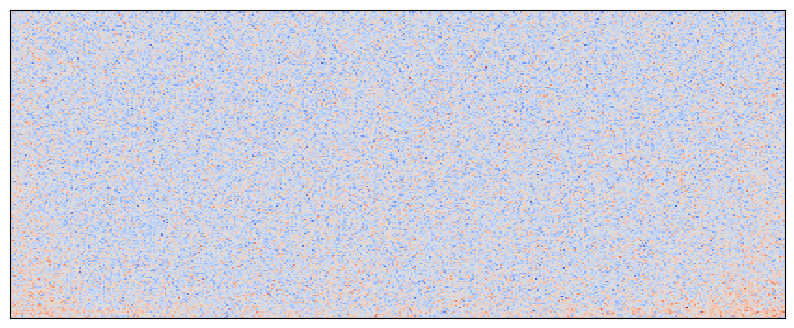

2025-04-06 18:33:01,000 - LIGHT_DEBUG - Sampling timestep 800/1000 X min/max: -5.22381, 4.59985 noise min/max: -6.67140, 5.73677 std/mean: 1.27496, -0.37990 

2025-04-06 18:33:02,123 - LIGHT_DEBUG - Normalized to range: [-1,1]


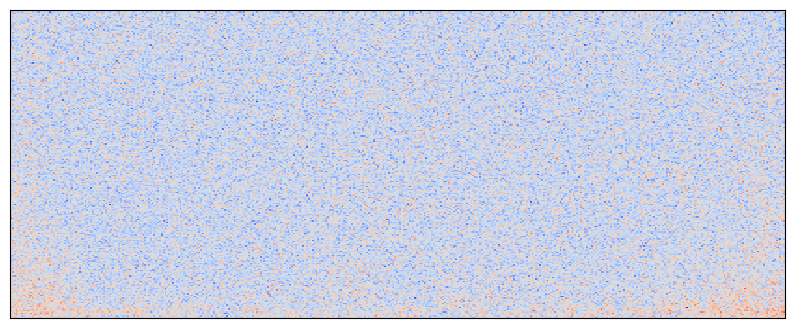

2025-04-06 18:33:16,000 - LIGHT_DEBUG - Sampling timestep 900/1000 X min/max: -5.93066, 4.76840 noise min/max: -7.45153, 5.97534 std/mean: 1.26440, -0.58017 

2025-04-06 18:33:16,427 - LIGHT_DEBUG - Normalized to range: [-1,1]


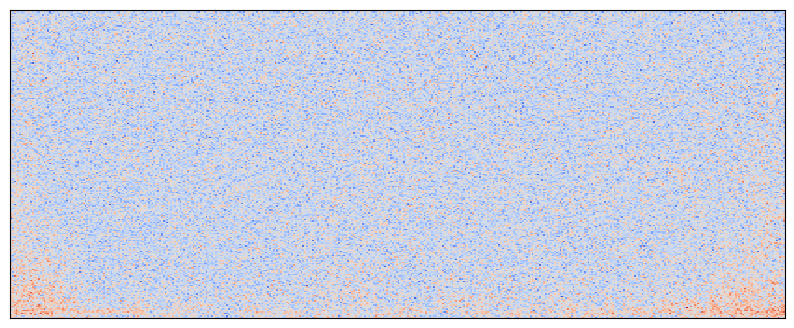

2025-04-06 18:33:30,000 - LIGHT_DEBUG - Sampling timestep 999/1000 X min/max: -5.71252, 5.00622 noise min/max: -5.99895, 5.06207 std/mean: 1.09358, -0.86193 


2025-04-06 18:33:30,606 - LIGHT_DEBUG - Final X min/max before return: -5.71252, 5.00622
2025-04-06 18:33:30,606 - INFO - Created 8 samples


In [5]:
#bwd_pass(diffusion, n_samples=8, file_name="test")
#x: ndarray = diffusion.bwd_diffusion_ddim(n_samples=8, sampling_timesteps=100, eta = 0.0)
x: ndarray = diffusion.bwd_diffusion_ddpm(n_samples=8, visual_freq=100)

-5.0830383 3.9512877


2025-04-06 18:33:30,707 - LIGHT_DEBUG - Normalized to range: [-1,1]


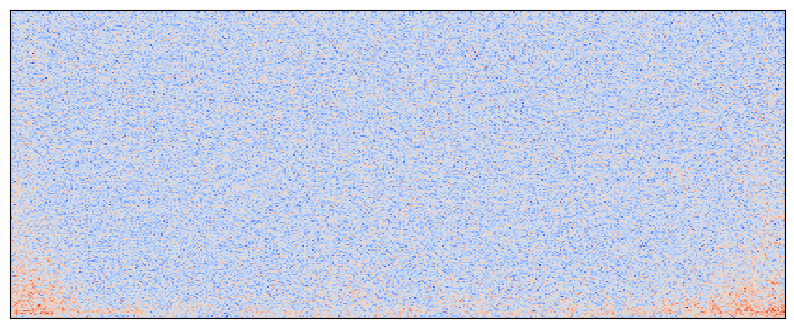

-5.384106 4.3199763


2025-04-06 18:33:30,834 - LIGHT_DEBUG - Normalized to range: [-1,1]


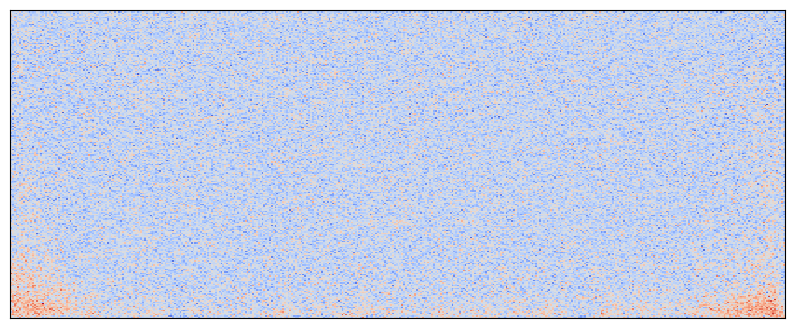

-5.7125196 4.7279353


2025-04-06 18:33:30,951 - LIGHT_DEBUG - Normalized to range: [-1,1]


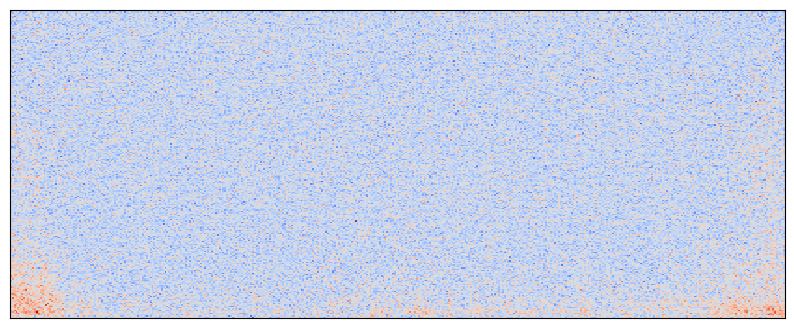

-5.2799263 4.961455


2025-04-06 18:33:31,071 - LIGHT_DEBUG - Normalized to range: [-1,1]


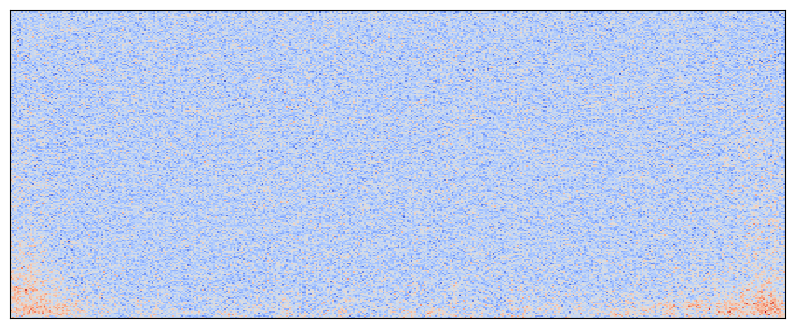

-5.6764407 4.0338917


2025-04-06 18:33:31,188 - LIGHT_DEBUG - Normalized to range: [-1,1]


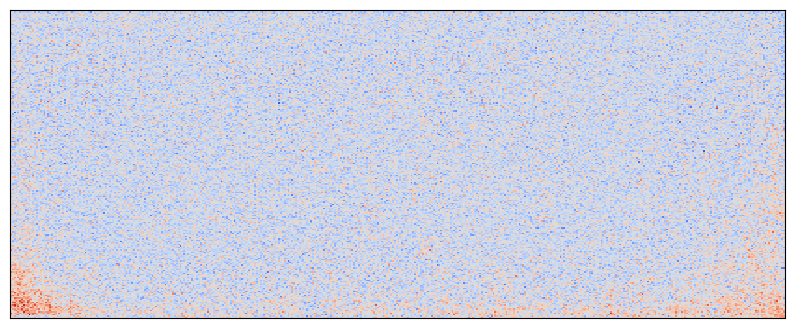

-5.4195876 5.006224


2025-04-06 18:33:31,309 - LIGHT_DEBUG - Normalized to range: [-1,1]


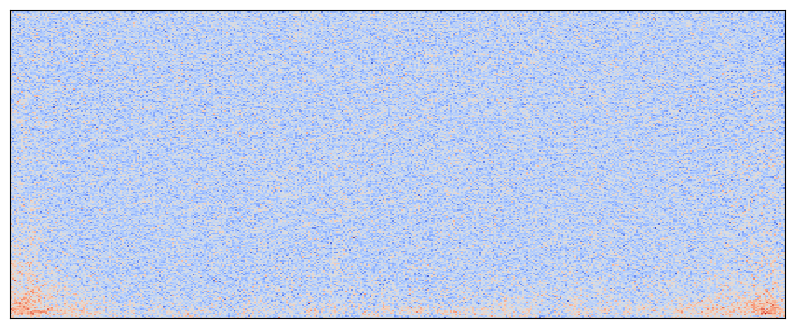

-5.099437 4.220213


2025-04-06 18:33:31,423 - LIGHT_DEBUG - Normalized to range: [-1,1]


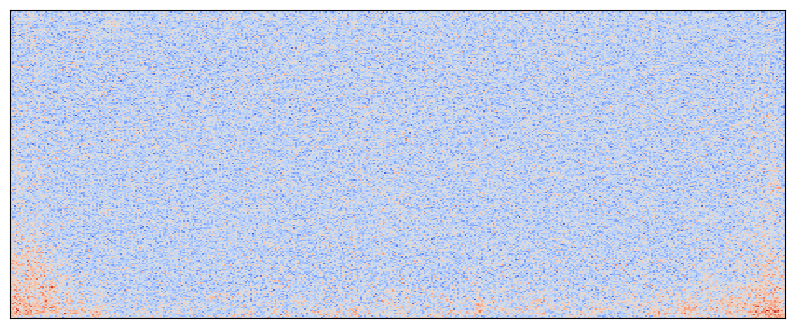

-5.1272836 4.185878


2025-04-06 18:33:31,541 - LIGHT_DEBUG - Normalized to range: [-1,1]


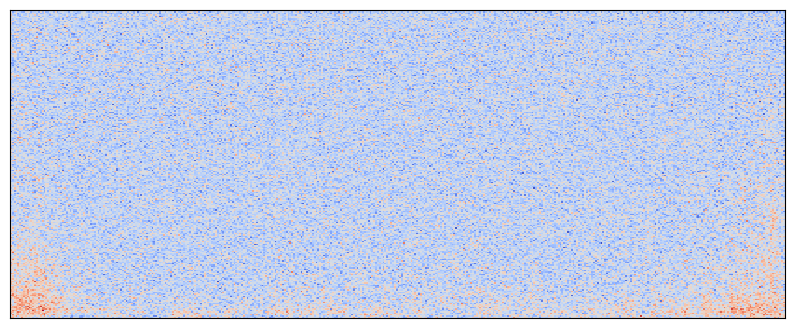

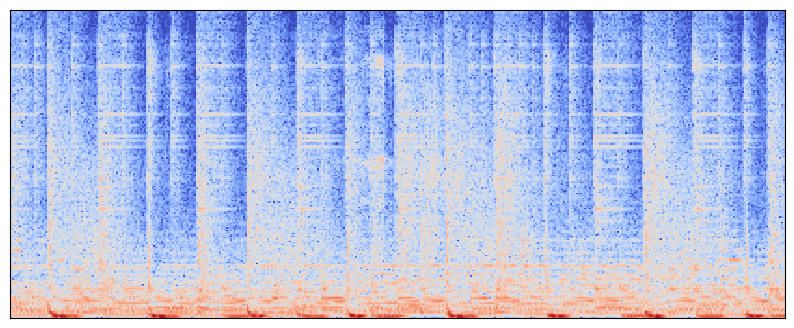

In [6]:
#print_eval_metrics(x)
for i in range(x.shape[0]):
    print(np.min(x[i,0]), np.max(x[i,0]), flush=True)
    visualize_spectogram(normalize(x[i,0], -1, 1))
#save_audio_file(spectrogram_to_audio(unnormalize(x[0,0]), conf["audio"].len_fft, conf["audio"].len_hop), path_to_remote_path("{}/{}".format(conf["paths"].result_path, "test.wav"), remote_kernel), conf["audio"].sample_rate)
visualize_spectogram(file[99])


### Save Model Architecture

In [ ]:
u_net.eval()
with torch.no_grad():
    example_x = torch.randn(8, 1, file.shape[-2], file.shape[-1]).to(device)
    example_t = torch.randint(0, 500, (8,), dtype=torch.long).to(device)

    script_model = torch.jit.trace(u_net,(example_x, example_t), check_trace=False)
torch.jit.save(script_model, path_to_remote_path("{}/{}".format(conf["paths"].result_path, model_name + ".pt"), remote_kernel))
#torchviz.make_dot(model(torch.randn(BATCH_SIZE, 1, file.shape[-2], file.shape[-1])), params=dict(model.named_parameters())).render(f"{RESULT_PATH}/{model_name}", format="png") #Not working
#logger.info(f"Saved model {path_to_remote_path(f"{RESULT_PATH}/{model_name}.pt", remote_kernel)}")